## Test del Pipeline bajo SearchSnippets 16 bits

### Lectura de Dataset

In [1]:
import re

class Dataset:
    
    def clean_str(self, string):
        """
        Tokenization/string cleaning for all datasets except for SST.
        Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
        """
        string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
        string = re.sub(r"\'s", " \'s", string)
        string = re.sub(r"\'ve", " \'ve", string)
        string = re.sub(r"n\'t", " n\'t", string)
        string = re.sub(r"\'re", " \'re", string)
        string = re.sub(r"\'d", " \'d", string)
        string = re.sub(r"\'ll", " \'ll", string)
        string = re.sub(r",", " , ", string)
        string = re.sub(r"!", " ! ", string)
        string = re.sub(r"\(", " \( ", string)
        string = re.sub(r"\)", " \) ", string)
        string = re.sub(r"\?", " \? ", string)
        string = re.sub(r"\s{2,}", " ", string)

        return string.strip().lower()
    
    #################################################################
    ##################### 20 Newsgroups #############################
    #################################################################
    
    path_train_20newsgroups = "../20NewsGroup/20ng-train-stemmed.txt"
    path_test_20newsgroups = "../20NewsGroup/20ng-test-stemmed.txt"
    
    target_names_20newsgroups = [
        "alt.atheism", 
        "comp.graphics",
        "comp.os.ms-windows.misc",
        "comp.sys.ibm.pc.hardware", 
        "comp.sys.mac.hardware",
        "comp.windows.x",
        "misc.forsale",
        "rec.autos",
        "rec.motorcycles",
        "rec.sport.baseball",
        "rec.sport.hockey",
        "sci.crypt",
        "sci.electronics",
        "sci.med",
        "sci.space",
        "soc.religion.christian",
        "talk.politics.guns",
        "talk.politics.mideast",
        "talk.politics.misc",
        "talk.religion.misc"
    ]
    
    def read_20newsgroups_file(self, path_test_20newsgroups):
        data = []
        target = []
        
        with open(path_test_20newsgroups) as file:
            for index, line in enumerate(file):
                tokens_count = len(line.split())

                if tokens_count > 1 and tokens_count <= 301:
                    category, text = line.split(None, 1)
                    data.append(self.clean_str(text))
                    target.append(self.target_names_20newsgroups.index(category))
                
        return data, target
        
    
    def fetch_20newsgroups(self, subset = "train"):
        dataset = {'data': None,  'target': None , 'target_names': self.target_names_20newsgroups}
    
        if subset == 'train':
            dataset['data'], dataset['target'] = self.read_20newsgroups_file(self.path_train_20newsgroups)
        elif subset == 'test':
            dataset['data'], dataset['target'] = self.read_20newsgroups_file(self.path_test_20newsgroups)
        elif subset == 'all':
            data_train, target_train = self.read_20newsgroups_file(self.path_train_20newsgroups)
            data_test, target_test = self.read_20newsgroups_file(self.path_test_20newsgroups)
            
            dataset['data'], dataset['target'] = data_train + data_test, target_train + target_test
        
        return dataset
    
    #################################################################
    ##################### SearchSnippets ############################
    #################################################################
    
    path_train_search_snippets = "../SearchSnippets/train.txt"
    path_test_search_snippets = "../SearchSnippets/test.txt"
    
    target_names_search_snippets = [
        "business",
        "computers",
        "culture-arts-entertainment",
        "education-science",
        "engineering",
        "health",
        "politics-society",
        "sports"
    ]
    
    def read_search_snippets_file(self, path_test_search_snippets):
        data = []
        target = []
        
        with open(path_test_search_snippets, encoding="utf8") as file:
            for index, line in enumerate(file):
                tokens_count = len(line.split())
               
                if tokens_count > 1 and tokens_count <= 301:
                    text, category = line.rsplit(None, 1)
                    data.append(self.clean_str(text))
                    target.append(self.target_names_search_snippets.index(category))
                
        return data, target
        
    
    def fetch_search_snippets(self, subset = "train"):
        dataset = {'data': None,  'target': None , 'target_names': self.target_names_search_snippets}
    
        if subset == 'train':
            dataset['data'], dataset['target'] = self.read_search_snippets_file(self.path_train_search_snippets)
        elif subset == 'test':
            dataset['data'], dataset['target'] = self.read_search_snippets_file(self.path_test_search_snippets)
        elif subset == 'all':
            data_train, target_train = self.read_search_snippets_file(self.path_train_search_snippets)
            data_test, target_test = self.read_search_snippets_file(self.path_test_search_snippets)
            
            dataset['data'], dataset['target'] = data_train + data_test, target_train + target_test
        
        return dataset

#### Carga del Dataset SearchSnippets

In [2]:
dataset = Dataset()
print("Dataset structure:")
train_dataset = dataset.fetch_search_snippets(subset = 'train')
print(train_dataset.keys())
print("\n")

print("Dataset example:")
print(train_dataset['data'][0])
print("\n")

print("Train dataset:")
print("Set size: {}".format(len(train_dataset['data'])))
print("\n")

print("Test dataset:")
test_dataset = dataset.fetch_search_snippets(subset = 'test')
print("Set size: {}".format(len(test_dataset['data'])))

Dataset structure:
dict_keys(['target', 'data', 'target_names'])


Dataset example:
manufacture manufacturer directory directory china taiwan products manufacturers directory taiwan china products manufacturer direcory exporter directory supplier directory suppliers


Train dataset:
Set size: 10060


Test dataset:
Set size: 2280


### Métodos de Preentrenamiento

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from pprint import pprint
import numpy as np
import threading
import math as mt
import multiprocessing
import time

class binaryCodes:
    
    vectorizer = TfidfVectorizer()
    
    def __init__(self, dataset, sigma = 2, method = 'weiss', k_neighbors = 7, c_coeff = 1, 
                 a_equal_coeff = 1, b_unequal_coeff = 0.1):
        self.tf_idf_features_matrix = self.tf_idf(dataset['data'])
        self.distance_matrix = self.euclidean_distance(self.tf_idf_features_matrix)
        self.labels = dataset['target']
        self.sigma = sigma
        self.method = method
        self.k_neighbors = k_neighbors
        self.c_coeff = c_coeff
        self.a_equal_coeff = a_equal_coeff
        self.b_unequal_coeff = b_unequal_coeff
        
    def tf_idf(self, data):
        return self.vectorizer.fit_transform(data)
    
    def euclidean_distance(self, tf_idf_features):
        return euclidean_distances(tf_idf_features, tf_idf_features)
    
    def parallel_operation(self, row_interval, w):
        for row in range(row_interval[0], row_interval[1]):
            for column in range(row, w.shape[1]):
                
                if self.method == 'weiss':
                    value = np.exp(-self.distance_matrix[row][column]**2/self.sigma**2)
                    
                elif self.method == 'chinese_weiss':
                  
                    row_neighbors = self.distance_matrix[row].argsort()[1:self.k_neighbors+1]
                    column_neighbors = self.distance_matrix[column].argsort()[1:self.k_neighbors+1]
                    
                    if row in column_neighbors or column in row_neighbors:
                        value = self.c_coeff*np.exp(-self.distance_matrix[row][column]**2/(2*self.sigma**2))
                    else:
                        value = 0
                        
                elif self.method == 'chinese_weiss_supervised':
                    
                    row_neighbors = self.distance_matrix[row].argsort()[1:self.k_neighbors+1]
                    column_neighbors = self.distance_matrix[column].argsort()[1:self.k_neighbors+1]
                    
                    if row in column_neighbors or column in row_neighbors:
                        if self.labels[row] == self.labels[column]:
                            value = self.a_equal_coeff*np.exp(-self.distance_matrix[row][column]**2/(2*self.sigma**2))
                        else:
                            value = self.b_unequal_coeff*np.exp(-self.distance_matrix[row][column]**2/(2*self.sigma**2))
                    else:
                        value = 0
                    
                w[row, column] = value
                
                if row != column:
                    w[column, row] = value
        
    def parallel_operation2(self, row_interval, w_matrix, d):
        for row in range(row_interval[0], row_interval[1]):
            sum_row = np.sum(w_matrix[row])
            d[row, row] = sum_row
                
    def w_matrix(self):
        
        print("Calculating W matrix using {} method ...".format(self.method))
        
        data_size, _ = self.tf_idf_features_matrix.shape

        start_time = time.time()

        w = np.zeros((data_size, data_size))

        cores_count = multiprocessing.cpu_count()
        bounds = list(range(mt.floor(data_size/cores_count), 
                            data_size-data_size%cores_count+1, mt.floor(data_size/cores_count)))

        bounds[-1] += data_size%cores_count

        threads = list()

        lower_bound = 0

        for index, upper_bound in enumerate(bounds):
            threads.append(threading.Thread(target = self.parallel_operation, args=([lower_bound, upper_bound], w)))
            lower_bound = upper_bound

        for thread in threads:
            thread.start()

        for thread in threads:
            thread.join()

        elapsed_time = time.time() - start_time

        print("Time to compute: {} min".format(elapsed_time/60))

        print("Nonzero elements count: {}".format(np.count_nonzero(w)))
        print("Ratio: {}".format(np.count_nonzero(w)/data_size**2))

        return w
    
    def d_matrix(self, w_matrix):
        
        print("Calculating D matrix using {} method ...".format(self.method))
        
        data_size, _ = self.tf_idf_features_matrix.shape
        
        start_time = time.time()
        
        d = np.zeros((data_size, data_size))

        cores_count = multiprocessing.cpu_count()
        bounds = list(range(mt.floor(data_size/cores_count), 
                            data_size-data_size%cores_count+1, mt.floor(data_size/cores_count)))

        bounds[-1] += data_size%cores_count

        threads = list()

        lower_bound = 0

        for index, upper_bound in enumerate(bounds):
            threads.append(threading.Thread(target = self.parallel_operation2, 
                                            args=([lower_bound, upper_bound], w_matrix, d)))
            lower_bound = upper_bound
            
        for thread in threads:
            thread.start()

        for thread in threads:
            thread.join()

        elapsed_time = time.time() - start_time
        
        print("Time to compute: {} min".format(elapsed_time/60))

        return d
    
    def binary_codes(self, hash_len = 64):
        
        data_size, _ = self.tf_idf_features_matrix.shape
        sigma_str = str(self.sigma).replace('.', '')
        c_coeff_str = str(self.c_coeff).replace('.', '')
        a_equal_coeff_str = str(self.a_equal_coeff).replace('.', '')
        b_unequal_coeff_str = str(self.b_unequal_coeff).replace('.', '')
        
        try:
            hash_codes = np.load('hash_codes-{}_{}_{}_{}_{}_{}_{}_{}.npy'.format(data_size, hash_len, self.method, 
                                     sigma_str, c_coeff_str, a_equal_coeff_str, b_unequal_coeff_str, self.k_neighbors))    
            
            print("Using preexisting hash codes")

        except:
        
            print("Calculating hash codes")
        
            w_matrix = self.w_matrix()
            d_matrix = self.d_matrix(w_matrix)

            global_start_time = time.time()

            sub_martix = d_matrix-w_matrix
            eigen_values, eigen_vectors = np.linalg.eig(sub_martix)

            eigen_values = np.delete(eigen_values, 0)
            eigen_vectors = np.delete(eigen_vectors, 0, 1)

            min_eigen_values = np.argsort(eigen_values)
           
            count = 0
            hash_codes = list()

            for i in range(hash_len):
                min_eigen_values[count]
                hash_codes.append(eigen_vectors[:, min_eigen_values[count]])
                count += 1

            hash_codes = np.asarray(hash_codes).transpose()

            threshold = lambda x: 1 if x>=0 else 0 
            vfunc = np.vectorize(threshold)

            hash_codes = vfunc(hash_codes)

            elapsed_time = time.time() - global_start_time

            print("\n")
            print("Total Time: {} min".format(elapsed_time/60))

            np.save('hash_codes-{}_{}_{}_{}_{}_{}_{}_{}.npy'.format(data_size, hash_len, self.method, 
                        sigma_str, c_coeff_str, a_equal_coeff_str, b_unequal_coeff_str, self.k_neighbors), hash_codes)
        
        return hash_codes

#### Weiss

In [4]:
hash_codes = binaryCodes(train_dataset, sigma = 1, method = 'weiss')
hash_codes = hash_codes.binary_codes(hash_len = 16)

Using preexisting hash codes


#### Wang

In [5]:
hash_codes = binaryCodes(train_dataset, sigma = 1, k_neighbors = 7, c_coeff = 1, method = 'chinese_weiss')
hash_codes = hash_codes.binary_codes(hash_len = 16)

Using preexisting hash codes


#### Wang Supervisado

In [6]:
hash_codes = binaryCodes(train_dataset, sigma = 1, k_neighbors = 7, a_equal_coeff = 1, b_unequal_coeff = 0.1, 
                         method = 'chinese_weiss_supervised')
hash_codes = hash_codes.binary_codes(hash_len = 16)

Using preexisting hash codes


### Word Embedding

In [7]:
%matplotlib inline

from nltk.stem.porter import PorterStemmer
from nltk import FreqDist
import pandas as pd
import csv

class prepare_input:
    
    def __init__(self, glove_data_file = "../Glove/glove.6B.50d.txt", steamming = False):
        self.glove_data_file = glove_data_file
        self.glove_vocab = dict()
        self.steamming = steamming
    
    def load_glove_embedding(self):
        if len(self.glove_vocab) != 0:
            print('Glove is already loaded')
            return

        stemmer = PorterStemmer()
        
        with open(self.glove_data_file, encoding="utf8") as file:
            for line in file:
                split_line = line.split()
                word = split_line[0]
                embedding = list(float(val) for val in split_line[1:])
                if self.steamming:
                    stemmed_word = stemmer.stem(word)
                    #print('word: {} stemmed word: {}'.format(word, stemmed_word))
                    if stemmed_word in self.glove_vocab.keys():
                        #print("Collision Problem:")
                        #print(word)
                        #print(stemmed_word)
                        #print('previous vector:')
                        #print(self.glove_vocab[stemmed_word])
                        #print('new vector:')
                        #print(embedding)
                        continue
                    else:
                        self.glove_vocab[stemmed_word] = embedding
                else:    
                    self.glove_vocab[word] = embedding
        
    def to_glove_embedding(self, dataset):
        
        start_time = time.time()
        
        if len(self.glove_vocab) == 0:
            print('The embedding is not loaded yet')
            return 

        embedded_data = list()
        
        features = pd.read_table(self.glove_data_file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
        features_means = features.describe().loc['mean'].values
        features_std = features.describe().loc['std'].values
        
        missing_words = dict()
        tokens = list()
        missing_tokens = list()
        
        for document in dataset['data']:
            embedded_document = list()
            sentence = document.split()
            
            for word in sentence:
                tokens.append(word)
                if word in self.glove_vocab.keys():
                    embedded_document.append(self.glove_vocab[word])
                else:
                    missing_tokens.append(word)
                    if word not in missing_words.keys():
                        
                        generated_vector = []
                        
                        for i in range(len(features_means)):
                            normal_dist = np.random.normal(features_means[i], features_std[i], 10000)
                            selected_element = np.random.choice(normal_dist)
                            generated_vector.append(selected_element)
                        
                        missing_words[word] = generated_vector
                        
                    embedded_document.append(missing_words[word])
                    
            embedded_data.append(embedded_document)
            
        elapsed_time = time.time() - start_time
        
        count_tokens = len(tokens)
        count_words = len(list(set(tokens)))
        count_missing_tokens = len(missing_tokens)
        count_missing_words = len(missing_words)
        
        print("Time to compute: {} min".format(elapsed_time/60))
        print("\n")
        print("Number of tokens: {}".format(count_tokens))
        print("Vocabulary size: {}".format(count_words))
        print("Missing tokes: {}".format(count_missing_tokens))
        print("Missing words: {}".format(count_missing_words))
        print("Token coverage: {} or {}%".format(count_tokens-count_missing_tokens, 
                                                 100*(count_tokens-count_missing_tokens)/count_tokens))
        print("Vocabulary coverage: {} or {}%".format(count_words-count_missing_words, 
                                                      100*(count_words-count_missing_words)/count_words))
    
        freqDis = FreqDist(tokens)
        freqDis.plot(30, title='Word Frequency')
        
        freqDis = FreqDist(missing_tokens)
        freqDis.plot(30, title='Missing Word Frequency')

        print('\nVocabulary: {}'.format(len(self.glove_vocab)))
        print('\nMissing Word: {}'.format(len(missing_words)))
        
        self.glove_vocab = {**self.glove_vocab, **missing_words}
        
        print('\nCombinated Vocabulary: {}'.format(len(self.glove_vocab)))
        
        return embedded_data
    
    def add_padding(self, embedded_dataset, padding_symbol = 100.0):
        document_sizes = list(len(document) for document in embedded_dataset)
        max_document_size = max(document_sizes)
        
        for index in range(len(document_sizes)):
            diference = max_document_size - len(embedded_dataset[index])
            for _ in range(diference):
                padding_vector = [padding_symbol] * len(embedded_dataset[index][0])
                embedded_dataset[index].append(padding_vector)
        
        return embedded_dataset
    
    def encode_hash(self, hash_code):
        encode_hash_code = list()
        for bit in hash_code:
            if bit == 0:
                encode_hash_code.append([1, 0])
            elif bit == 1:
                encode_hash_code.append([0, 1])
            else:
                encode_hash_code.append([0, 0])
        return np.asarray(encode_hash_code)
    
    def encode_hashes(self, hash_codes):
        encoded_hashes = []
        for hash_code in hash_codes:
            encoded_hashes.append(self.encode_hash(hash_code))
        return np.asarray(encoded_hashes)
  
    def decode_hash(self, encode_hash):
        hash_code = list()
        for bit in encode_hash:
            if np.array_equal(bit, np.array([0,0])):
                hash_code.append(2) 
            else:
                hash_code.append(np.argmax(bit)) 
        return np.asarray(hash_code)
    
    def decode_hashes(self, hash_codes):
        encoded_hashes = []
        for hash_code in hash_codes:
            encoded_hashes.append(self.decode_hash(hash_code))
        return np.asarray(encoded_hashes)
    
    def shift_hash_code(self, hash_code):
        y_shift_temp = [2]
        for i in range(len(hash_code) - 1):
            y_shift_temp.append(hash_code[i])
        return np.asarray(y_shift_temp)
    
    def shift_hash_codes(self, hash_codes):
        encoded_hashes = []
        for hash_code in hash_codes:
            encoded_hashes.append(self.shift_hash_code(hash_code))
        return np.asarray(encoded_hashes)

#### Train

Time to compute: 2.529539529482524 min


Number of tokens: 181889
Vocabulary size: 25143
Missing tokes: 10899
Missing words: 6979
Token coverage: 170990 or 94.00788392920957%
Vocabulary coverage: 18164 or 72.24277134789007%


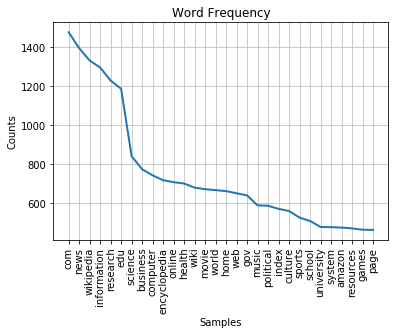

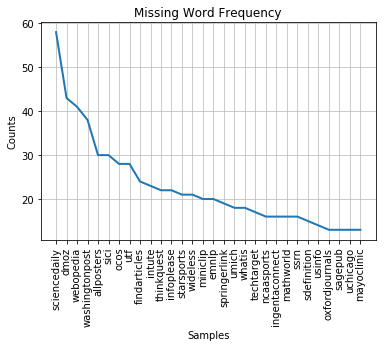


Vocabulary: 400000

Missing Word: 6979

Combinated Vocabulary: 406979
Dimensiones del train embedding: (10060, 50, 50)


In [8]:
prepare = prepare_input(steamming = False)
prepare.load_glove_embedding()
glove_em_before_padding = prepare.to_glove_embedding(train_dataset)
glove_em = prepare.add_padding(glove_em_before_padding)
glove_em = np.asarray(glove_em)
print("Dimensiones del train embedding: {}".format(glove_em.shape))

#### Validation Split

In [9]:
validation_indexes = []

In [10]:
import random
import math
import copy

random.seed(7)

val_glove_em = []
num_samples = glove_em.shape[0]

print('Conjunto de entrenamiento {}'.format(num_samples))
print('Conjunto de validacion: {}\n'.format(math.ceil(num_samples*0.2)))

actual_num_samples = num_samples

for _ in range(0, math.ceil(num_samples*0.2)):
    selected_index = random.randint(0, actual_num_samples-1)
    validation_indexes.append(selected_index)
    
    #print(selected_index)
    
    selected_glove_em = copy.deepcopy(glove_em[selected_index])
    val_glove_em.append(selected_glove_em)
    glove_em = np.delete(glove_em, selected_index, 0)    
    actual_num_samples -= 1
    
val_glove_em = np.asarray(val_glove_em).reshape((len(val_glove_em), glove_em.shape[1], glove_em.shape[2]))    

print('Dimensiones del test set {}'.format(glove_em.shape))
print('Dimensiones del val set {}'.format(val_glove_em.shape))

Conjunto de entrenamiento 10060
Conjunto de validacion: 2012

Dimensiones del test set (8048, 50, 50)
Dimensiones del val set (2012, 50, 50)


#### Test

Time to compute: 0.6775940855344137 min


Number of tokens: 41403
Vocabulary size: 9874
Missing tokes: 2217
Missing words: 1694
Token coverage: 39186 or 94.64531555684371%
Vocabulary coverage: 8180 or 82.84383228681385%


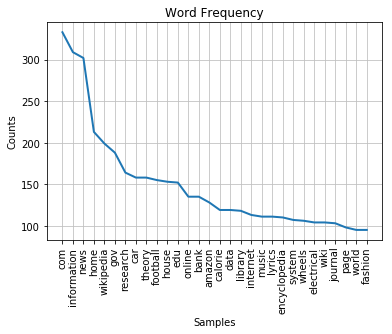

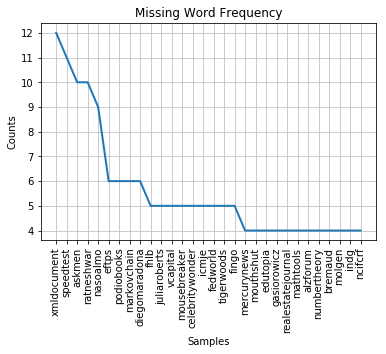


Vocabulary: 406979

Missing Word: 1694

Combinated Vocabulary: 408673

Dimensiones del test embedding: 2280


In [11]:
glove_em_test = prepare.to_glove_embedding(test_dataset)
print("\nDimensiones del test embedding: {}".format(len(glove_em_test)))

### Metricas de Evaluación

In [12]:
from sklearn.neighbors import DistanceMetric

class hashingDatabase:
    
    def __init__(self):
        self.database = []
        self.labels = []
    
    def add_element(self, element, label):
        self.database.append(element)
        self.labels.append(label)
        
    def find_neighbours_position(self, element):
        distance_metric = DistanceMetric.get_metric('hamming')
        distance_vector = distance_metric.pairwise(element, self.database)
        return np.argsort(distance_vector)
    
    def evaluate_P_K(self, element, label, k = None):
        neighbours_position = self.find_neighbours_position(element)[0][:k]
        matched = 0
        #print(neighbours_position)
        for neighbour_position in neighbours_position:
            #print('neighbor label: {}'.format(self.labels[neighbour_position]))
            if self.labels[neighbour_position] == label:
                matched += 1
        #print('precision {}'.format(matched/k))        
        return matched/k

### Red Neuronal y Pruebas de Recuperación

En esta seccion se presentan la red neuronal entrenada utilizando los prehashes generados por los 3 diferentes metodos de preentrenamiento, asi como una medida de su rendimiento.

### Weiss

#### Prehashes

In [13]:
hash_codes = binaryCodes(train_dataset, sigma = 1, method = 'weiss')

binary_codes = hash_codes.binary_codes(hash_len = 16)

#pprint(binary_codes[0])
#print(len(binary_codes))
#print("\n")

shifted_codes = prepare.shift_hash_codes(binary_codes)
#pprint(shifted_codes[0])
#print(len(shifted_codes))
#print("\n")

encoded_hash_codes = prepare.encode_hashes(binary_codes)
#pprint(encoded_hash_codes[0])
#print(len(encoded_hash_codes))
#print("\n")

encoded_shited_hash_codes = prepare.encode_hashes(shifted_codes)
#pprint(encoded_shited_hash_codes[0])
#print(len(encoded_shited_hash_codes))
#print("\n")

Using preexisting hash codes


In [14]:
val_encoded_shited_hash_codes = []
val_encoded_hash_codes = []

print('Dimensiones del shifted hash codes'.format(encoded_shited_hash_codes.shape))
print('Dimensiones del hash codes'.format(encoded_hash_codes.shape))

for selected_index in validation_indexes:
       
    selected_encoded_shited_hash_codes = copy.deepcopy(encoded_shited_hash_codes[selected_index])
    selected_encoded_hash_codes = copy.deepcopy(encoded_hash_codes[selected_index])
    
    val_encoded_shited_hash_codes.append(selected_encoded_shited_hash_codes)
    val_encoded_hash_codes.append(selected_encoded_hash_codes)
    
    encoded_shited_hash_codes = np.delete(encoded_shited_hash_codes, selected_index, 0)
    encoded_hash_codes = np.delete(encoded_hash_codes, selected_index, 0)

val_encoded_shited_hash_codes = np.asarray(val_encoded_shited_hash_codes).reshape((len(val_encoded_shited_hash_codes), encoded_shited_hash_codes.shape[1], encoded_shited_hash_codes.shape[2]))
val_encoded_hash_codes = np.asarray(val_encoded_hash_codes).reshape((len(val_encoded_hash_codes), encoded_hash_codes.shape[1], encoded_hash_codes.shape[2]))

print('Dimensiones del shifted hash codes {}'.format(encoded_shited_hash_codes.shape))
print('Dimensiones del hash codes {}'.format(encoded_hash_codes.shape))
print('Dimensiones del validation shifted hash codes {}'.format(val_encoded_shited_hash_codes.shape))
print('Dimensiones del validation hash codes {}'.format(val_encoded_hash_codes.shape))
print('\n')

Dimensiones del shifted hash codes
Dimensiones del hash codes
Dimensiones del shifted hash codes (8048, 16, 2)
Dimensiones del hash codes (8048, 16, 2)
Dimensiones del validation shifted hash codes (2012, 16, 2)
Dimensiones del validation hash codes (2012, 16, 2)




#### Red Neuronal

Using TensorFlow backend.


num_features: 50
hash_features: 2
latent_dim: 256
len_hash: 16
num_samples: 8048
max_lenght: 50


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 8048 samples, validate on 2012 samples
Epoch 1/200
8048/8048 [==============================] - 20s 3ms/step - loss: 0.1614 - acc: 0.9291 - val_loss: 0.0368 - val_acc: 0.9935
Epoch 2/200
8048/8048 [==============================] - 20s 2ms/step - loss: 0.0362 - acc: 0.9931 - val_loss: 0.0356 - val_acc: 0.9936
Epoch 3/200
8048/8048 [==============================] - 20s 2ms/step - loss: 0.0338 - acc: 0.9932 - val_loss: 0.0327 - val_acc: 0.9936
Epoch 4/200
8048/8048 [==============================] - 19s 2ms/step - loss: 0.0308 - acc: 0.9932 - val_loss: 0.0301 - val_acc: 0.9935
Epoch 5/200
8048/8048 [==============================] - 19s 2ms/step - loss: 0.0291 - acc: 0.9932 - val_loss: 0

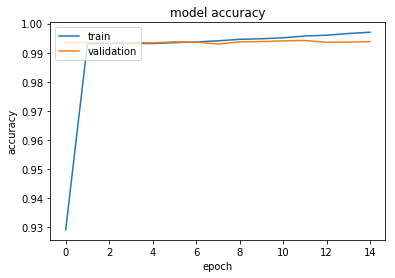

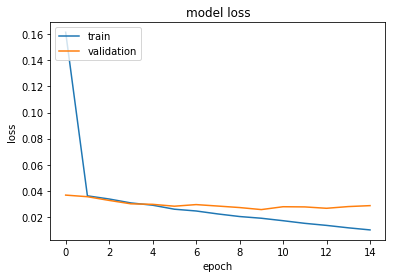

finish training


In [15]:
%matplotlib inline

from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Masking
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from pprint import pprint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import time
import math 
import random
import copy 


num_features = glove_em.shape[2]
hash_features = encoded_hash_codes.shape[2]
latent_dim = 256
len_hash = encoded_hash_codes.shape[1]
num_samples = glove_em.shape[0]
max_lenght = glove_em.shape[1]

print("num_features: {}".format(num_features))
print("hash_features: {}".format(hash_features))
print("latent_dim: {}".format(latent_dim))
print("len_hash: {}".format(len_hash))
print("num_samples: {}".format(num_samples))
print("max_lenght: {}".format(max_lenght))
print("\n")

# Training Model

# Define encoder, an input sequence and process it.
encoder_inputs = Input(shape=(None, num_features))
encoder_inputs_mask = Masking(mask_value = 100.0)(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_mask)

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, hash_features))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(hash_features, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience = 5, verbose = 1),
    #ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

start_time = time.time()

history = model.fit(
    [glove_em, encoded_shited_hash_codes], 
    encoded_hash_codes, 
    epochs = 200, 
    validation_data = ([val_glove_em, val_encoded_shited_hash_codes], val_encoded_hash_codes),
    callbacks = callbacks
)

elapsed_time = time.time() - start_time
print("Time to compute: {} min".format(elapsed_time/60))

# summarize history for accuracy
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print('finish training')

In [16]:
# Inference Model

print('Modelo de Inferencia')
# define encoder inference model
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def predict_hash_code(input_seq):

    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, hash_features))
    hash_code = []
    
    prepare = prepare_input()

    for _ in range(len_hash):

        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        #pprint(output_tokens)
        
        decoded_hash = prepare.decode_hash(output_tokens[0])
        #pprint(decoded_hash)
        
        hash_code.append(decoded_hash[0]);
        
        selected_bit = np.argmax(output_tokens[0])        
        target_seq = np.zeros((1, 1, hash_features))
        target_seq[0, 0, selected_bit] = 1
        states_value = [h, c]
    
        #print(target_seq)
        
    return np.asarray(hash_code)

Modelo de Inferencia


In [17]:
database = hashingDatabase()

#print(len(glove_em_before_padding))
for i in range(len(glove_em_before_padding)):
    #print(len(glove_em_before_padding[i]))
    #print(i)
    element = np.asarray(glove_em_before_padding[i])
    #print(element.shape)
    element = element.reshape((1, element.shape[0], element.shape[1]))
    #print(element.shape)
    #break
    hash_code = predict_hash_code(element)
    database.add_element(hash_code, train_dataset['target'][i])
    
print(len(database.database))
print(len(database.labels))

10060
10060


In [18]:
k_values = [1, 5, 10, 15, 20, 50, 100, 150, 200]

for k in k_values:
    precisions = []
    for i in range(len(glove_em_test)):
        example = np.asarray(glove_em_test[i])
        #print(example.shape)
        example = example.reshape((1, example.shape[0], example.shape[1]))
        #print(example.shape)
        #break
        hash_code = predict_hash_code(example).reshape((1, len_hash))
        #print(hash_code)
        #print(tiny_test_dataset['target'][i])
        #print('Precision')
        #print('hash: {}'.format(hash_code));
        #print('target: {}'.format(tiny_test_dataset['target'][i]))
        precision = database.evaluate_P_K(hash_code, test_dataset['target'][i], k)
        #print(precision)
        #print('\n')
        precisions.append(precision)

    print("precision at {} equals to {}".format(k, np.mean(precisions)))

precision at 1 equals to 0.14692982456140352
precision at 5 equals to 0.16017543859649122
precision at 10 equals to 0.1621929824561404
precision at 15 equals to 0.1639766081871345
precision at 20 equals to 0.163859649122807
precision at 50 equals to 0.1573859649122807
precision at 100 equals to 0.14822368421052634
precision at 150 equals to 0.14442690058479532
precision at 200 equals to 0.11919517543859648


### Wang

#### Prehashes

In [19]:
hash_codes = binaryCodes(train_dataset, sigma = 1, k_neighbors = 7, c_coeff = 1, method = 'chinese_weiss')

binary_codes = hash_codes.binary_codes(hash_len = 16)

#pprint(binary_codes[0])
#print(len(binary_codes))
#print("\n")

shifted_codes = prepare.shift_hash_codes(binary_codes)
#pprint(shifted_codes[0])
#print(len(shifted_codes))
#print("\n")

encoded_hash_codes = prepare.encode_hashes(binary_codes)
#pprint(encoded_hash_codes[0])
#print(len(encoded_hash_codes))
#print("\n")

encoded_shited_hash_codes = prepare.encode_hashes(shifted_codes)
#pprint(encoded_shited_hash_codes[0])
#print(len(encoded_shited_hash_codes))
#print("\n")

Using preexisting hash codes


In [20]:
val_encoded_shited_hash_codes = []
val_encoded_hash_codes = []

print('Dimensiones del shifted hash codes'.format(encoded_shited_hash_codes.shape))
print('Dimensiones del hash codes'.format(encoded_hash_codes.shape))

for selected_index in validation_indexes:
       
    selected_encoded_shited_hash_codes = copy.deepcopy(encoded_shited_hash_codes[selected_index])
    selected_encoded_hash_codes = copy.deepcopy(encoded_hash_codes[selected_index])
    
    val_encoded_shited_hash_codes.append(selected_encoded_shited_hash_codes)
    val_encoded_hash_codes.append(selected_encoded_hash_codes)
    
    encoded_shited_hash_codes = np.delete(encoded_shited_hash_codes, selected_index, 0)
    encoded_hash_codes = np.delete(encoded_hash_codes, selected_index, 0)

val_encoded_shited_hash_codes = np.asarray(val_encoded_shited_hash_codes).reshape((len(val_encoded_shited_hash_codes), encoded_shited_hash_codes.shape[1], encoded_shited_hash_codes.shape[2]))
val_encoded_hash_codes = np.asarray(val_encoded_hash_codes).reshape((len(val_encoded_hash_codes), encoded_hash_codes.shape[1], encoded_hash_codes.shape[2]))

print('Dimensiones del shifted hash codes {}'.format(encoded_shited_hash_codes.shape))
print('Dimensiones del hash codes {}'.format(encoded_hash_codes.shape))
print('Dimensiones del validation shifted hash codes {}'.format(val_encoded_shited_hash_codes.shape))
print('Dimensiones del validation hash codes {}'.format(val_encoded_hash_codes.shape))
print('\n')

Dimensiones del shifted hash codes
Dimensiones del hash codes
Dimensiones del shifted hash codes (8048, 16, 2)
Dimensiones del hash codes (8048, 16, 2)
Dimensiones del validation shifted hash codes (2012, 16, 2)
Dimensiones del validation hash codes (2012, 16, 2)




#### Red Neuronal

num_features: 50
hash_features: 2
latent_dim: 256
len_hash: 16
num_samples: 8048
max_lenght: 50


Train on 8048 samples, validate on 2012 samples
Epoch 1/200
8048/8048 [==============================] - 20s 3ms/step - loss: 0.4930 - acc: 0.7394 - val_loss: 0.4097 - val_acc: 0.8166
Epoch 2/200
8048/8048 [==============================] - 20s 2ms/step - loss: 0.3693 - acc: 0.8352 - val_loss: 0.3522 - val_acc: 0.8444
Epoch 3/200
8048/8048 [==============================] - 20s 2ms/step - loss: 0.3280 - acc: 0.8565 - val_loss: 0.3301 - val_acc: 0.8569
Epoch 4/200
8048/8048 [==============================] - 20s 2ms/step - loss: 0.2953 - acc: 0.8735 - val_loss: 0.2921 - val_acc: 0.8767
Epoch 5/200
8048/8048 [==============================] - 19s 2ms/step - loss: 0.2670 - acc: 0.8863 - val_loss: 0.2807 - val_acc: 0.8818
Epoch 6/200
8048/8048 [==============================] - 19s 2ms/step - loss: 0.2423 - acc: 0.8987 - val_loss: 0.2607 - val_acc: 0.8917
Epoch 7/200
8048/8048 [===============

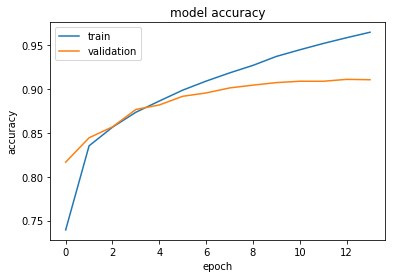

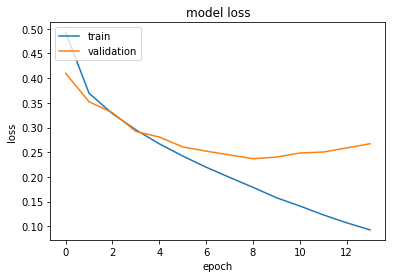

finish training


In [21]:
%matplotlib inline

from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Masking
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from pprint import pprint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import time
import math 
import random
import copy 


num_features = glove_em.shape[2]
hash_features = encoded_hash_codes.shape[2]
latent_dim = 256
len_hash = encoded_hash_codes.shape[1]
num_samples = glove_em.shape[0]
max_lenght = glove_em.shape[1]

print("num_features: {}".format(num_features))
print("hash_features: {}".format(hash_features))
print("latent_dim: {}".format(latent_dim))
print("len_hash: {}".format(len_hash))
print("num_samples: {}".format(num_samples))
print("max_lenght: {}".format(max_lenght))
print("\n")

# Training Model

# Define encoder, an input sequence and process it.
encoder_inputs = Input(shape=(None, num_features))
encoder_inputs_mask = Masking(mask_value = 100.0)(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_mask)

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, hash_features))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(hash_features, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience = 5, verbose = 1),
    #ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

start_time = time.time()

history = model.fit(
    [glove_em, encoded_shited_hash_codes], 
    encoded_hash_codes, 
    epochs = 200, 
    validation_data = ([val_glove_em, val_encoded_shited_hash_codes], val_encoded_hash_codes),
    callbacks = callbacks
)

elapsed_time = time.time() - start_time
print("Time to compute: {} min".format(elapsed_time/60))

# summarize history for accuracy
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print('finish training')

In [22]:
# Inference Model

print('Modelo de Inferencia')
# define encoder inference model
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def predict_hash_code(input_seq):

    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, hash_features))
    hash_code = []
    
    prepare = prepare_input()

    for _ in range(len_hash):

        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        #pprint(output_tokens)
        
        decoded_hash = prepare.decode_hash(output_tokens[0])
        #pprint(decoded_hash)
        
        hash_code.append(decoded_hash[0]);
        
        selected_bit = np.argmax(output_tokens[0])        
        target_seq = np.zeros((1, 1, hash_features))
        target_seq[0, 0, selected_bit] = 1
        states_value = [h, c]
    
        #print(target_seq)
        
    return np.asarray(hash_code)

Modelo de Inferencia


In [23]:
database = hashingDatabase()

#print(len(glove_em_before_padding))
for i in range(len(glove_em_before_padding)):
    #print(len(glove_em_before_padding[i]))
    #print(i)
    element = np.asarray(glove_em_before_padding[i])
    #print(element.shape)
    element = element.reshape((1, element.shape[0], element.shape[1]))
    #print(element.shape)
    #break
    hash_code = predict_hash_code(element)
    database.add_element(hash_code, train_dataset['target'][i])
    
print(len(database.database))
print(len(database.labels))

10060
10060


In [24]:
k_values = [1, 5, 10, 15, 20, 50, 100, 150, 200]

for k in k_values:
    precisions = []
    for i in range(len(glove_em_test)):
        example = np.asarray(glove_em_test[i])
        #print(example.shape)
        example = example.reshape((1, example.shape[0], example.shape[1]))
        #print(example.shape)
        #break
        hash_code = predict_hash_code(example).reshape((1, len_hash))
        #print(hash_code)
        #print(tiny_test_dataset['target'][i])
        #print('Precision')
        #print('hash: {}'.format(hash_code));
        #print('target: {}'.format(tiny_test_dataset['target'][i]))
        precision = database.evaluate_P_K(hash_code, test_dataset['target'][i], k)
        #print(precision)
        #print('\n')
        precisions.append(precision)

    print("precision at {} equals to {}".format(k, np.mean(precisions)))

precision at 1 equals to 0.6381578947368421
precision at 5 equals to 0.6147368421052632
precision at 10 equals to 0.5994298245614035
precision at 15 equals to 0.5935087719298245
precision at 20 equals to 0.5936622807017544
precision at 50 equals to 0.5881491228070176
precision at 100 equals to 0.5738859649122807
precision at 150 equals to 0.5624122807017544
precision at 200 equals to 0.5549912280701755


### Wang Supervised

#### Prehashes

In [25]:
hash_codes = binaryCodes(train_dataset, sigma = 1, k_neighbors = 7, a_equal_coeff = 1, b_unequal_coeff = 0.1, 
                         method = 'chinese_weiss_supervised')

binary_codes = hash_codes.binary_codes(hash_len = 16)

#pprint(binary_codes[0])
#print(len(binary_codes))
#print("\n")

shifted_codes = prepare.shift_hash_codes(binary_codes)
#pprint(shifted_codes[0])
#print(len(shifted_codes))
#print("\n")

encoded_hash_codes = prepare.encode_hashes(binary_codes)
#pprint(encoded_hash_codes[0])
#print(len(encoded_hash_codes))
#print("\n")

encoded_shited_hash_codes = prepare.encode_hashes(shifted_codes)
#pprint(encoded_shited_hash_codes[0])
#print(len(encoded_shited_hash_codes))
#print("\n")

Using preexisting hash codes


In [26]:
val_encoded_shited_hash_codes = []
val_encoded_hash_codes = []

print('Dimensiones del shifted hash codes'.format(encoded_shited_hash_codes.shape))
print('Dimensiones del hash codes'.format(encoded_hash_codes.shape))

for selected_index in validation_indexes:
       
    selected_encoded_shited_hash_codes = copy.deepcopy(encoded_shited_hash_codes[selected_index])
    selected_encoded_hash_codes = copy.deepcopy(encoded_hash_codes[selected_index])
    
    val_encoded_shited_hash_codes.append(selected_encoded_shited_hash_codes)
    val_encoded_hash_codes.append(selected_encoded_hash_codes)
    
    encoded_shited_hash_codes = np.delete(encoded_shited_hash_codes, selected_index, 0)
    encoded_hash_codes = np.delete(encoded_hash_codes, selected_index, 0)

val_encoded_shited_hash_codes = np.asarray(val_encoded_shited_hash_codes).reshape((len(val_encoded_shited_hash_codes), encoded_shited_hash_codes.shape[1], encoded_shited_hash_codes.shape[2]))
val_encoded_hash_codes = np.asarray(val_encoded_hash_codes).reshape((len(val_encoded_hash_codes), encoded_hash_codes.shape[1], encoded_hash_codes.shape[2]))

print('Dimensiones del shifted hash codes {}'.format(encoded_shited_hash_codes.shape))
print('Dimensiones del hash codes {}'.format(encoded_hash_codes.shape))
print('Dimensiones del validation shifted hash codes {}'.format(val_encoded_shited_hash_codes.shape))
print('Dimensiones del validation hash codes {}'.format(val_encoded_hash_codes.shape))
print('\n')

Dimensiones del shifted hash codes
Dimensiones del hash codes
Dimensiones del shifted hash codes (8048, 16, 2)
Dimensiones del hash codes (8048, 16, 2)
Dimensiones del validation shifted hash codes (2012, 16, 2)
Dimensiones del validation hash codes (2012, 16, 2)




#### Red Neuronal

num_features: 50
hash_features: 2
latent_dim: 256
len_hash: 16
num_samples: 8048
max_lenght: 50


Train on 8048 samples, validate on 2012 samples
Epoch 1/200
8048/8048 [==============================] - 21s 3ms/step - loss: 0.4532 - acc: 0.7662 - val_loss: 0.3257 - val_acc: 0.8564
Epoch 2/200
8048/8048 [==============================] - 19s 2ms/step - loss: 0.2423 - acc: 0.9017 - val_loss: 0.1928 - val_acc: 0.9236
Epoch 3/200
8048/8048 [==============================] - 19s 2ms/step - loss: 0.1750 - acc: 0.9318 - val_loss: 0.1550 - val_acc: 0.9386
Epoch 4/200
8048/8048 [==============================] - 19s 2ms/step - loss: 0.1447 - acc: 0.9435 - val_loss: 0.1417 - val_acc: 0.9451
Epoch 5/200
8048/8048 [==============================] - 20s 2ms/step - loss: 0.1258 - acc: 0.9518 - val_loss: 0.1293 - val_acc: 0.9501
Epoch 6/200
8048/8048 [==============================] - 19s 2ms/step - loss: 0.1125 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9510
Epoch 7/200
8048/8048 [===============

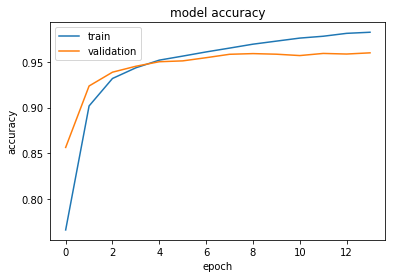

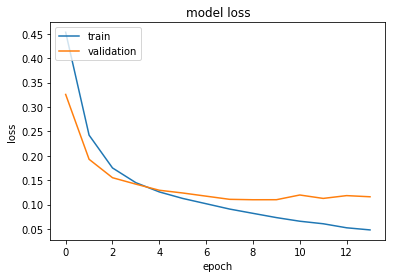

finish training


In [27]:
%matplotlib inline

from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Masking
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from pprint import pprint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import time
import math 
import random
import copy 


num_features = glove_em.shape[2]
hash_features = encoded_hash_codes.shape[2]
latent_dim = 256
len_hash = encoded_hash_codes.shape[1]
num_samples = glove_em.shape[0]
max_lenght = glove_em.shape[1]

print("num_features: {}".format(num_features))
print("hash_features: {}".format(hash_features))
print("latent_dim: {}".format(latent_dim))
print("len_hash: {}".format(len_hash))
print("num_samples: {}".format(num_samples))
print("max_lenght: {}".format(max_lenght))
print("\n")

# Training Model

# Define encoder, an input sequence and process it.
encoder_inputs = Input(shape=(None, num_features))
encoder_inputs_mask = Masking(mask_value = 100.0)(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_mask)

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, hash_features))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(hash_features, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience = 5, verbose = 1),
    #ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

start_time = time.time()

history = model.fit(
    [glove_em, encoded_shited_hash_codes], 
    encoded_hash_codes, 
    epochs = 200, 
    validation_data = ([val_glove_em, val_encoded_shited_hash_codes], val_encoded_hash_codes),
    callbacks = callbacks
)

elapsed_time = time.time() - start_time
print("Time to compute: {} min".format(elapsed_time/60))

# summarize history for accuracy
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print('finish training')

In [28]:
# Inference Model

print('Modelo de Inferencia')
# define encoder inference model
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def predict_hash_code(input_seq):

    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, hash_features))
    hash_code = []
    
    prepare = prepare_input()

    for _ in range(len_hash):

        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        #pprint(output_tokens)
        
        decoded_hash = prepare.decode_hash(output_tokens[0])
        #pprint(decoded_hash)
        
        hash_code.append(decoded_hash[0]);
        
        selected_bit = np.argmax(output_tokens[0])        
        target_seq = np.zeros((1, 1, hash_features))
        target_seq[0, 0, selected_bit] = 1
        states_value = [h, c]
    
        #print(target_seq)
        
    return np.asarray(hash_code)

Modelo de Inferencia


In [29]:
database = hashingDatabase()

#print(len(glove_em_before_padding))
for i in range(len(glove_em_before_padding)):
    #print(len(glove_em_before_padding[i]))
    #print(i)
    element = np.asarray(glove_em_before_padding[i])
    #print(element.shape)
    element = element.reshape((1, element.shape[0], element.shape[1]))
    #print(element.shape)
    #break
    hash_code = predict_hash_code(element)
    database.add_element(hash_code, train_dataset['target'][i])
    
print(len(database.database))
print(len(database.labels))

10060
10060


In [30]:
k_values = [1, 5, 10, 15, 20, 50, 100, 150, 200]

for k in k_values:
    precisions = []
    for i in range(len(glove_em_test)):
        example = np.asarray(glove_em_test[i])
        #print(example.shape)
        example = example.reshape((1, example.shape[0], example.shape[1]))
        #print(example.shape)
        #break
        hash_code = predict_hash_code(example).reshape((1, len_hash))
        #print(hash_code)
        #print(tiny_test_dataset['target'][i])
        #print('Precision')
        #print('hash: {}'.format(hash_code));
        #print('target: {}'.format(tiny_test_dataset['target'][i]))
        precision = database.evaluate_P_K(hash_code, test_dataset['target'][i], k)
        #print(precision)
        #print('\n')
        precisions.append(precision)

    print("precision at {} equals to {}".format(k, np.mean(precisions)))

precision at 1 equals to 0.775438596491228
precision at 5 equals to 0.780438596491228
precision at 10 equals to 0.7867982456140351
precision at 15 equals to 0.793859649122807
precision at 20 equals to 0.7910526315789475
precision at 50 equals to 0.7854561403508773
precision at 100 equals to 0.7765482456140351
precision at 150 equals to 0.7768245614035088
precision at 200 equals to 0.7754166666666665


In [ ]:
############################################################################################################################

### Test con las modificaciones propuestas por el profesor

### More Layers